# Stock Screener

### Dans ce stock screener, j'aurais besoin de : <br><br>
<ol>
    <li>Données sur forex et crypto en temps réel </li><br>
    <li>Une fréquence de mise à jour, qui se fera toute les 30 secondes </li><br>
    <li>L'analyse financière puis une Data Visualisation sur streamLit </li><br>
    <li>Ajouter des alertes de prix, des flux de données éco </li><br>
</ol>

    



In [39]:
from datetime import datetime, timedelta
from yahoo_fin import stock_info as si
import pandas as pd
import mplfinance as mpf

end_date = datetime.now()
start_date = end_date-timedelta(days=600)
top5TradableStocks = si.get_day_most_active().head()["Symbol"]


###------ Fonction ------###

def prix_historique(ticker):
    ticker = ticker.upper()
    historical_prices = si.get_data(ticker, start_date=start_date, end_date=end_date)
    return historical_prices['close'].rolling(80).mean(), historical_prices

ma80, historical_prices = prix_historique("AAPL")

# Donne la tendance de fond
def tendancesDeF(ticker):
    if ma80.iloc[-1] > si.get_live_price(ticker):
        return ":arrow_lower_right:"
    else :
        return ":arrow_upper_right:"

# Indique si Oui ou Non il faut trader ce stock en ce moment
def Tradable(myTicker):
    for symbol in si.get_day_most_active()["Symbol"]:
        if symbol == myTicker.upper():
            return ":white_check_mark:"
    return ":no_entry:"


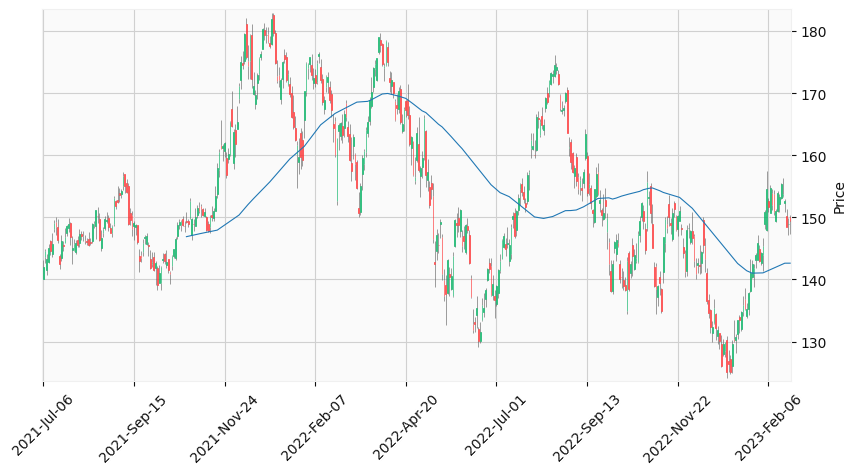

In [40]:
def graph():
    mpf_params = {
        'type': 'candle', 
        'mav': 80, 
        'volume': False, 
        'figratio': (12,6), 
        'figscale': 0.75
    }
    return mpf.plot(historical_prices, **mpf_params, tight_layout=True, style='yahoo')

graph()

In [41]:
import requests
import pandas as pd
from bs4 import BeautifulSoup
import numpy as np

# URL de la page à récupérer
url = 'https://www.investing.com/economic-calendar/'

# Effectuer une requête GET
response = requests.get(url)

# Créer un objet BeautifulSoup à partir de la réponse
soup = BeautifulSoup(response.text, 'html.parser')

# Trouver la table avec l'ID "economicCalendarData"
table = soup.find('table', {'id': 'economicCalendarData'})

# Extraire les noms de colonnes depuis le premier <thead>
thead = table.find_all('thead')[0]
cols = [col.get_text().strip() for col in thead.find_all('th')]

# Créer une liste vide pour stocker les données
data = []

# Extraire les données depuis la deuxième <tbody>
tbody = table.find('tbody')
for row in tbody.find_all('tr'):
    # Extraire les colonnes de chaque ligne
    cols_row = [col.get_text().strip() for col in row.find_all('td')]
    
    # Mettre à jour la colonne "Importance" en fonction de la valeur de l'attribut "title" de chaque élément "td"
    for i, col in enumerate(row.find_all('td')):
        if 'High Volatility Expected' in col.get('title', ''):
            cols_row[i] = 'fort'
        elif 'Moderate Volatility Expected' in col.get('title', ''):
            cols_row[i] = 'moyen'
        elif 'Low Volatility Expected' in col.get('title', ''):
            cols_row[i] = 'faible'

    # Supprimer la première colonne correspondant à la date du jour
    cols_row.pop(0)
    # Ajouter les colonnes à la liste de données
    data.append(cols_row)


# Créer un DataFrame pandas à partir des données et des noms de colonnes
df = pd.DataFrame(data, columns=cols[1:])
df = df.iloc[1:]
df = df.drop('', axis=1)
df.iloc[:, 0:1] = df.iloc[:, 0:1].where(df.iloc[:, 0:1].apply(lambda x: x.str.strip() != ''), other=np.nan)
df.iloc[:, 3:] = df.iloc[:, 3:].where(df.iloc[:, 3:].apply(lambda x: x.str.strip() != ''), other=np.nan)
df = df.rename(columns={'Cur.': 'Currency', 'Imp.': 'Importance'})
df.dropna(subset=["Currency"], inplace=True)
df = df.reset_index(drop=True)

# Afficher le contenu du premier <td> avec la classe "theDay"
print(soup.find_all('td', {'class': 'theDay'})[0].get_text().strip())

# Afficher le DataFrame
df

Friday, February 24, 2023


,Currency,Importance,Event,Actual,Forecast,Previous
0,SGD,faible,Industrial Production (YoY) (Jan),-2.7%,2.9%,-2.6%
1,SGD,faible,Industrial Production (MoM) (Jan),-1.1%,-0.1%,2.9%
2,EUR,fort,German GDP (QoQ) (Q4),NaN,-0.2%,0.5%
3,EUR,moyen,German GDP (YoY) (Q4),NaN,1.1%,1.4%
4,EUR,moyen,GfK German Consumer Climate (Mar),NaN,-30.4,-33.9
...,...,...,...,...,...,...
57,JPY,moyen,CFTC JPY speculative net positions,NaN,NaN,-21.6K
58,NZD,faible,CFTC NZD speculative net positions,NaN,NaN,2.2K
59,RUB,moyen,CFTC RUB speculative positions,NaN,NaN,-9.5K
60,EUR,moyen,CFTC EUR speculative net positions,NaN,NaN,134.3K


## Sentiment sur les réseaux

In [42]:
import finnhub
import pandas as pd

finnhub_client = finnhub.Client(api_key="cfrnl81r01qr5t5shjh0cfrnl81r01qr5t5shjhg")

sentiment_data = finnhub_client.stock_social_sentiment('AAPL')

social_sentiment_reddit = pd.DataFrame(sentiment_data["reddit"])
social_sentiment_twitter = pd.DataFrame(sentiment_data["twitter"])

#social_sentiment_reddit
social_sentiment_twitter

,atTime,mention,positiveScore,negativeScore,positiveMention,negativeMention,score
0,2023-02-24 04:00:00,129,0.936358,-0.952807,65,46,0.162706
1,2023-02-24 03:00:00,167,0.940659,-0.952747,72,70,0.007701
2,2023-02-24 02:00:00,55,0.910250,-0.973773,23,25,-0.075277
3,2023-02-24 01:00:00,74,0.937187,-0.958279,41,19,0.356995
4,2023-02-24 00:00:00,118,0.963410,-0.938141,58,39,0.208622
5,2023-02-23 23:00:00,225,0.945022,-0.942783,129,68,0.310716
6,2023-02-23 22:00:00,230,0.952896,-0.940410,115,91,0.123005
7,2023-02-23 21:00:00,208,0.955824,-0.933616,111,70,0.237640
8,2023-02-23 20:00:00,377,0.944071,-0.938560,190,150,0.120533
9,2023-02-23 19:00:00,331,0.943402,-0.940573,128,160,-0.109628


## Market News

In [43]:
import finnhub
import datetime

finnhub_client = finnhub.Client(api_key="cfrnl81r01qr5t5shjh0cfrnl81r01qr5t5shjhg")

general_news = pd.DataFrame(finnhub_client.general_news('general', min_id=0))

def ChangeTime(unix_timestamp):
    date = datetime.datetime.fromtimestamp(unix_timestamp)
    return date.strftime('%d/%m/%Y %H:%M:%S')

general_news["datetime"]

general_news["datetime"] = general_news["datetime"].apply(ChangeTime)
general_news

,category,datetime,headline,id,image,related,source,summary,url
0,top news,24/02/2023 04:05:00,"Dow Jones Newswires: Tom Lee, leveraged-buyout...",7237914,https://mw3.wsj.net/mw5/content/logos/mw_logo_...,,MarketWatch,Lee was among the first to engineer leveraged ...,https://www.marketwatch.com/story/tom-lee-leve...
1,top news,24/02/2023 01:01:00,Dow Jones Newswires: U.K. consumer confidence ...,7237883,https://mw3.wsj.net/mw5/content/logos/mw_logo_...,,MarketWatch,U.K. consumer confidence improved more than ex...,https://www.marketwatch.com/story/uk-consumer-...
2,top news,24/02/2023 00:43:00,Dow Jones Newswires: Japan’s core CPI hits mor...,7237884,https://mw3.wsj.net/mw5/content/logos/mw_logo_...,,MarketWatch,Japan's core consumer prices excluding fresh f...,https://www.marketwatch.com/story/japan-core-c...
3,top news,24/02/2023 00:38:04,Jim Cramer says market volatility reflects bac...,7237852,https://image.cnbcfm.com/api/v1/image/10710996...,,CNBC,"""We've got a schizophrenic market, where each ...",https://www.cnbc.com/2023/02/23/cramer-says-ma...
4,top news,23/02/2023 23:45:00,Chuck Jaffe: Timing the market is a loser’s ga...,7237845,https://images.mktw.net/im-374251/social,,MarketWatch,Bill Nygren's Oakmark Fund has stayed the cour...,https://www.marketwatch.com/story/timing-the-m...
...,...,...,...,...,...,...,...,...,...
95,top news,23/02/2023 03:07:00,Sunwoda Electric Vehicle Battery Seeking $580 ...,7237898,https://data.bloomberglp.com/company/sites/2/2...,,Bloomberg,The electric-vehicle battery unit of Sunwoda E...,https://www.bloomberg.com/news/articles/2023-0...
96,top news,23/02/2023 03:06:04,A Top-Performing Fund Plans to Pare China Prop...,7237899,https://data.bloomberglp.com/company/sites/2/2...,,Bloomberg,One of Asia’s best-performing bond funds is lo...,https://www.bloomberg.com/news/articles/2023-0...
97,top news,23/02/2023 03:00:23,Spy Plane Pilot Took Selfie With China Balloon...,7237900,https://data.bloomberglp.com/company/sites/2/2...,,Bloomberg,The US Air Force pilot glances back as a camer...,https://www.bloomberg.com/news/articles/2023-0...
98,top news,23/02/2023 02:52:01,'Cash is no longer trash': Market forecaster J...,7237351,https://image.cnbcfm.com/api/v1/image/10645753...,,CNBC,High-yield savings accounts and Treasurys are ...,https://www.cnbc.com/2023/02/22/cash-no-longer...


In [45]:
top5UnderRateStocks = si.get_undervalued_large_caps().head()["Symbol"]
top5UnderRateStocks

0    ITUB
1     FCX
2     PBR
3    VALE
4     MRO
Name: Symbol, dtype: object